In [66]:
import itertools
import math
import numpy as np
import os
import soundfile as sf
import scipy
import sys
import vesper.old_bird.old_bird_detector_redux as ob
sys.path.append("../src")

import localmodule

In [29]:
def design_oldbird_filter(settings):
    f0 = settings.filter_f0
    f1 = settings.filter_f1
    bw = settings.filter_bw
    fs2 = localmodule.get_sample_rate()
    bands = np.array([0, f0 - bw, f0, f1, f1 + bw, fs2]) / fs2
    desired = np.array([0, 0, 1, 1, 0, 0])
    coefficients = ob._firls(settings.filter_length, bands, desired)
    return coefficients

In [70]:
#data_dir = localmodule.get_data_dir()
data_dir = "/Users/vl238/spl2017_data"
dataset_name = localmodule.get_dataset_name()
full_audio_name = "_".join([dataset_name, "full-audio"])
full_audio_dir = os.path.join(data_dir, full_audio_name)
sample_rate = localmodule.get_sample_rate()

# Load audio excerpt
unit_str = "unit01"
signal_start = 3600 * sample_rate
signal_length = 60 * sample_rate
in_unit_path = os.path.join(full_audio_dir, unit_str + ".flac")
full_audio_object = sf.SoundFile(in_unit_path)
full_audio_object.seek(signal_start)
signal = full_audio_object.read(signal_length)

settings = ob._TSEEP_SETTINGS

# Design filter
fir = design_oldbird_filter(settings)

# Apply filter
fir_signal = scipy.signal.fftconvolve(signal, fir, mode='valid')

# Square
squared_signal = fir_signal * fir_signal

# Integrate
integration_length = int(round(settings.integration_time * sample_rate))
integrator = np.ones(integration_length) / integration_length
integrated_signal = scipy.signal.fftconvolve(squared_signal, integrator)

# Delay and divide
delay = math.floor(settings.ratio_delay * sample_rate)
divided_signal = integrated_signal[delay:] / integrated_signal[:-delay]

array([  2.40194578e+04,   5.93040245e+02,   4.48232050e+02, ...,
         1.52285473e-02,   1.49748816e-02,   3.40211031e-03])

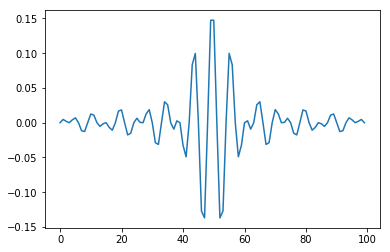

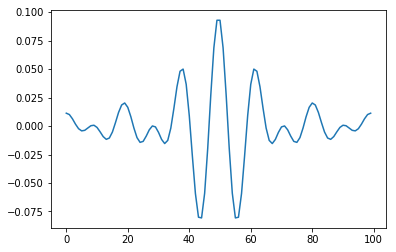

In [30]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure();
plt.plot(design_oldbird_filter(ob._TSEEP_SETTINGS))
plt.figure();
plt.plot(design_oldbird_filter(ob._THRUSH_SETTINGS))

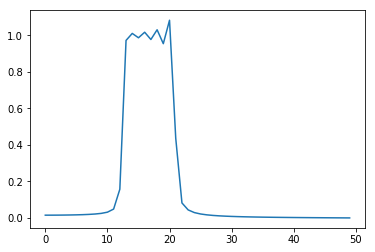

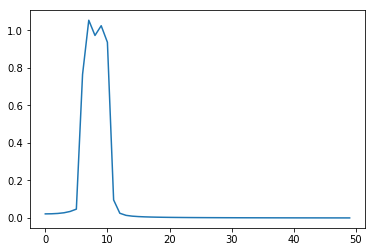

In [36]:
%matplotlib inline
from matplotlib import pyplot as plt
import scipy
plt.figure();
plt.plot(np.abs(np.fft.fft(design_oldbird_filter(ob._TSEEP_SETTINGS)))[:50])
plt.figure();
plt.plot(np.abs(np.fft.fft(design_oldbird_filter(ob._THRUSH_SETTINGS)))[:50])

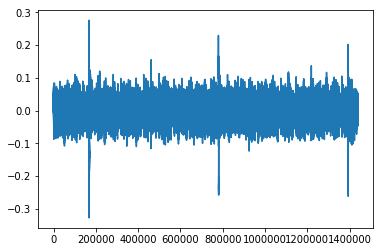

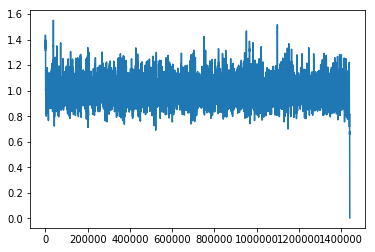

In [73]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure();
plt.plot(signal);
plt.figure();
plt.plot(divided_signal[1000:])